# 库导入与功能说明


tensorflow：核心深度学习框架，提供计算图、自动求导等功能。

keras：TensorFlow 的高级 API，简化模型构建（如Sequential模型、层定义）。

layers：包含各种神经网络层（如Dense全连接层、Dropout正则化层）。

数据处理与可视化：

- matplotlib.pyplot：用于绘制训练过程图表（如准确率曲线、混淆矩阵）。


- numpy：处理多维数组和数学运算，要求版本 1.24.x 以确保兼容性。


- pandas：读取 CSV 文件并处理表格数据。

In [20]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np  # 确保导入的是 1.24 版本
import pandas as pd
from utils import *

In [21]:
# 设置中文字体
plt.rcParams["font.family"] = ["SimHei", "WenQuanYi Micro Hei", "Heiti TC"]

# 验证版本


In [22]:
print(f"NumPy 版本: {np.__version__}")    # 应输出 1.24.x
print(f"TensorFlow 版本: {tf.__version__}")  # 应输出 2.19.x

NumPy 版本: 1.24.3
TensorFlow 版本: 2.19.0


#  加载数据

读取 CSV 文件，加载 Fashion-MNIST 数据集的训练集和测试集，并将数据拆分为图像特征和标签

In [23]:
train = pd.read_csv("./dataset/fashion-mnist_train.csv")
test = pd.read_csv("./dataset/fashion-mnist_test.csv") 
(train_images, train_labels), (test_images, test_labels) = load_data(train,test)
#从加载的 CSV 数据中提取图像和标签，并拆分为训练集和测试集

# 像素值归一化

对图像像素值进行归一化处理，并查看训练集的形状信息。

In [24]:
train_images = train_images / 255.0  # 训练集归一化
test_images = test_images / 255.0  # 测试集归一化

In [25]:
train_images.shape,train_labels.shape

((60000, 784), (60000,))

# 构建 TensorFlow 数据集

将 NumPy 格式的图像和标签数据转换为 TensorFlow 的Dataset对象，以便高效地进行批量训练和测试。

核心步骤总览

- 定义数据集创建函数：将输入的图像和标签转换为可迭代的Dataset对象，支持数据打乱、批量处理和预取优化。


- 创建训练集和测试集：分别为训练集和测试集生成Dataset对象，设置不同的打乱策略（训练集打乱，测试集不打乱）。


- 获取数据集大小：记录训练集和测试集的样本数量，用于后续训练循环和结果统计。

In [26]:
# 创建数据集加载函数：将 NumPy 数组转换为可迭代的 Dataset 对象
def create_dataset(images, labels, batch_size, shuffle=False):
    #batch_size: 批量大小，每次迭代返回的样本数
    #shuffle: 是否打乱数据顺序
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(images), seed=42)  # 固定随机种子
    return dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

batch_size = 256
train_dataset = create_dataset(train_images, train_labels, batch_size, shuffle=True)
test_dataset = create_dataset(test_images, test_labels, batch_size, shuffle=False)
train_size = train_images.shape[0]
test_size = test_images.shape[0]

In [27]:
print(train_size,test_size)

60000 10000


# 数据可视化

从 Fashion-MNIST 训练数据集中随机选择一个样本，将其从一维像素向量恢复为 28×28 的图像并可视化，同时显示对应的中文标签。

核心步骤总览

- 标签映射定义：创建数字标签（0-9）到中文类别名称的映射关系。


- 样本选择与重塑：从训练集中选取特定索引的样本，将一维像素向量还原为二维图像矩阵。


- 图像可视化：使用 Matplotlib 绘制灰度图像，并显示对应的中文标签。

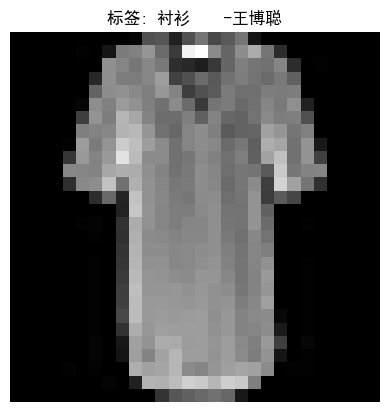

In [28]:
Named_labels = [' T恤', '裤子', '套衫', '连衣裙', '外套','凉鞋', '衬衫', '运动鞋', '包', '踝靴']
# 标签名称映射：用于将数字标签转换为人类可读的类别名称
index = 43
img = train_images[index].reshape(28, 28)#将一维像素向量重塑为 28×28 的二维图像（灰度图）
label = train_labels[index]
# 绘制图像并显示标签
plt.imshow(img, cmap='gray')
plt.title(f"标签: {Named_labels[label]}    -王博聪")
plt.axis('off')
plt.show()

# 全连接神经网络模型定义

定义了一个用于 Fashion-MNIST 图像分类的全连接神经网络（DNN）模型。全连接网络通过多层神经元之间的完全连接进行特征学习，适用于处理分类问题。

核心步骤总览

- 模型架构设计：使用 Keras 的Sequential API 按顺序堆叠各层。


- 输入层与数据展平：将 28×28 图像展平为 784 维向量


- 隐藏层构建：设置 3 个带 Dropout 正则化的全连接层，逐步提取特征。


- 输出层设计：使用 10 个神经元对应 10 个服装类别，输出未归一化的预测分数（logits）。


- 模型结构可视化：通过model.summary()打印网络层参数和结构。

In [29]:
model = keras.Sequential([
    layers.Input(shape=(784,)),  # 显式定义输入层
    layers.Flatten(),           # 不再需要 input_shape 参数
    layers.Dense(256, activation='relu',
                 kernel_initializer=keras.initializers.RandomNormal(stddev=0.01)),  # 推荐写法
    layers.Dropout(0.4),
    layers.Dense(128, activation='relu',
                 kernel_initializer=keras.initializers.RandomNormal(stddev=0.01)),
    layers.Dropout(0.2),
    layers.Dense(68, activation='relu',
                 kernel_initializer=keras.initializers.RandomNormal(stddev=0.01)),
    layers.Dense(10)
])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)                  │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │         200,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 68)                  │           8,772 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 10)                  │             690 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 243,318 (950.46 KB)

 Trainable params: 243,318 (950.46 KB)

 Non-trainable params: 0 (0.00 B)

# 损失函数与优化器配置

In [30]:
loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
#计算模型预测值与真实标签之间的交叉熵损失
optimizer = keras.optimizers.Adam(learning_rate=0.001, weight_decay=1e-4)  # 含 L2 正则

# 训练循环与评估
- 初始化参数与记录列表
- 训练阶段
- 测试阶段
- 记录结果

这段代码配置了深度学习模型训练的两个核心组件：损失函数和优化器。它们共同决定了模型如何从数据中学习、如何更新参数以及如何避免过拟合。

核心步骤总览

1. 损失函数配置：量化分类误差

选择 SparseCategoricalCrossentropy 损失函数处理多分类问题，直接支持整数标签（0-9）。设置 from_logits=True 适配模型未归一化的 logits 输出，内部自动应用 softmax 运算，避免手动计算导致的数值不稳定问题，确保损失计算高效且准确。

2. 优化器配置：驱动参数更新

采用 Adam 优化器实现自适应学习率调整，结合动量机制加速收敛。基础学习率设为 0.001 平衡训练速度与稳定性，添加 L2 正则化（weight_decay=1e-4）通过惩罚大权重抑制过拟合，提升模型泛化能力。

3. 协同训练机制：误差传导与参数优化

损失函数计算预测误差并生成梯度信号，优化器根据梯度方向和大小调整模型权重。L2 正则化在每次参数更新时施加约束，防止模型过度拟合训练数据。二者协同工作构成迭代训练循环，驱动模型从数据中学习有效特征。

In [31]:
# ----------------- 初始化参数与记录列表-----------------# 
num_epochs = 10  # 设置训练轮数
train_acc_list = []
test_acc_list = []
train_loss_list = []  # 训练损失列表
test_loss_list = []   #测试损失列表
for epoch in range(num_epochs):
    # ----------------- 训练阶段 -----------------
    train_loss_sum, train_acc_sum, train_samples = 0, 0, 0
    for X, y in train_dataset:
        # 梯度带：自动记录前向传播中的计算图，用于后续反向传播
        with tf.GradientTape() as tape:
            logits = model(X, training=True)
            batch_loss = loss_fn(y, logits)
            loss = tf.reduce_sum(batch_loss)
        
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        
        # 计算训练准确率和损失
        predictions = tf.argmax(logits, axis=1)
        train_acc_sum += tf.reduce_sum(tf.cast(tf.equal(predictions, tf.cast(y, tf.int64)), tf.int32)).numpy()
        train_loss_sum += loss.numpy()
        train_samples += y.shape[0]
    
    # ----------------- 测试阶段 -----------------
    test_loss_sum, test_acc_sum, test_samples = 0, 0, 0
    for X_test, y_test in test_dataset:
        logits = model(X_test, training=False)
        batch_loss = loss_fn(y_test, logits)
        test_loss_sum += tf.reduce_sum(batch_loss).numpy()
        
        predictions = tf.argmax(logits, axis=1)
        # 计算批次准确率
        test_acc_sum += tf.reduce_sum(tf.cast(tf.equal(predictions, tf.cast(y_test, tf.int64)), tf.int32)).numpy()
        test_samples += y_test.shape[0]
    
    # ----------------- 记录和输出结果 -----------------
    train_loss = train_loss_sum / train_samples
    train_acc = train_acc_sum / train_samples
    test_loss = test_loss_sum / test_samples
    test_acc = test_acc_sum / test_samples
    
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    test_loss_list.append(test_loss)
    test_acc_list.append(test_acc)
    
    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.3f}, Train Acc: {train_acc:.3f}, "
          f"Test Loss: {test_loss:.3f}, Test Acc: {test_acc:.3f}")

Epoch 1, Train Loss: 0.003, Train Acc: 0.656, Test Loss: 0.002, Test Acc: 0.808
Epoch 2, Train Loss: 0.002, Train Acc: 0.819, Test Loss: 0.002, Test Acc: 0.850
Epoch 3, Train Loss: 0.002, Train Acc: 0.841, Test Loss: 0.002, Test Acc: 0.857
Epoch 4, Train Loss: 0.002, Train Acc: 0.853, Test Loss: 0.001, Test Acc: 0.867
Epoch 5, Train Loss: 0.002, Train Acc: 0.861, Test Loss: 0.001, Test Acc: 0.867
Epoch 6, Train Loss: 0.001, Train Acc: 0.866, Test Loss: 0.001, Test Acc: 0.868
Epoch 7, Train Loss: 0.001, Train Acc: 0.870, Test Loss: 0.001, Test Acc: 0.881
Epoch 8, Train Loss: 0.001, Train Acc: 0.872, Test Loss: 0.001, Test Acc: 0.876
Epoch 9, Train Loss: 0.001, Train Acc: 0.874, Test Loss: 0.001, Test Acc: 0.880
Epoch 10, Train Loss: 0.001, Train Acc: 0.880, Test Loss: 0.001, Test Acc: 0.879


# 训练与测试准确率随轮次变化趋势图
- 训练准确率/损失曲线（蓝色）
- 测试准确率/损失曲线（橙色）
- X轴标签为训练轮次（Epoch）
- Y轴标签为准确率/损失值

通过可视化展示模型在训练过程中准确率和损失值随轮次的变化趋势
- 左侧子图：绘制训练准确率和测试准确率随训练轮次（Epoch）的变化曲线，直观展示模型的分类能力提升过程。
- 右侧子图：绘制训练损失和测试损失随训练轮次的变化曲线，反映模型优化目标的收敛情况。
- 对比分析：通过比较训练集和测试集的曲线，可以判断模型是否存在过拟合（训练准确率远高于测试准确率）或欠拟合（训练准确率提升缓慢）问题。

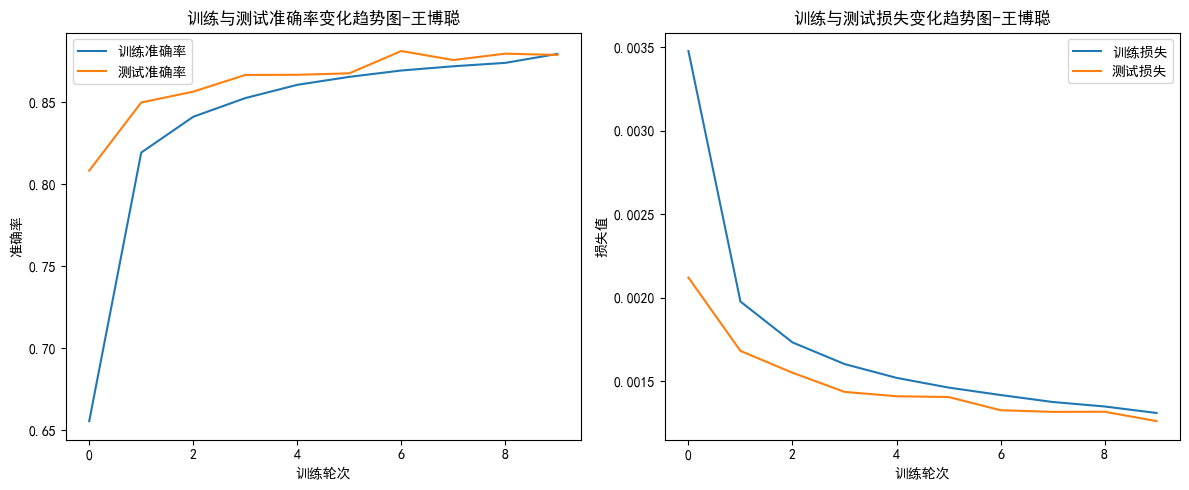

In [32]:
# 绘制训练与测试准确率随轮次变化趋势图
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_acc_list, label='训练准确率')
plt.plot(test_acc_list, label='测试准确率')
plt.xlabel('训练轮次')
plt.ylabel('准确率')
plt.title('训练与测试准确率变化趋势图-王博聪')
plt.legend()

# 新增：绘制训练与测试损失随轮次变化趋势图
plt.subplot(1, 2, 2)
plt.plot(train_loss_list, label='训练损失')
plt.plot(test_loss_list, label='测试损失')
plt.xlabel('训练轮次')
plt.ylabel('损失值')
plt.title('训练与测试损失变化趋势图-王博聪')
plt.legend()

plt.tight_layout()#自动调整子图间距，确保标签和标题不重叠，最后通过plt.show()显示完整图形。
plt.show()

# 单样本预测结果可视化（测试集）

从测试集中随机选取一个样本，将其图像、真实标签和模型预测结果进行可视化展示，以此验证模型的分类效果。

核心步骤总览

1. 获取测试批次数据：使用test_dataset.take(1)从测试集中提取一个批次的样本，包含图像数据X_batch和标签数据y_batch。


2. 选择目标样本并处理：手动指定索引I=88（或改为随机数），从批次中提取对应样本的图像数据，将其从 Tensor 转换为 NumPy 数组并重塑为 28×28 的二维矩阵，同时提取该样本的真实标签。


3. 模型预测与结果提取：将整个批次的图像数据输入模型，得到所有样本的预测 logits，通过tf.argmax获取目标样本预测概率最高的类别索引作为预测标签。


4. 图像可视化与标签显示：使用 Matplotlib 绘制样本图像，在标题中通过Named_labels将真实标签和预测标签映射为中文类别名称，并隐藏坐标轴以提升可视化效果。

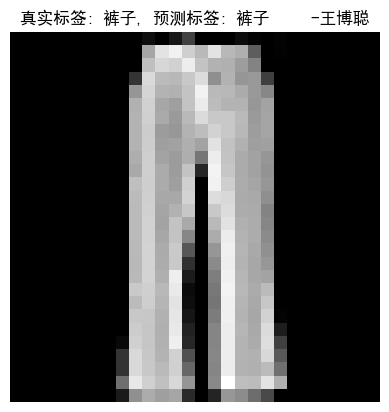

In [33]:
# 从测试集取一个批次
for X_batch, y_batch in test_dataset.take(1):
    break

I = 88
img = X_batch[I].numpy().reshape(28, 28)  # 转换为 NumPy 数组
true_label = y_batch[I].numpy()           # 提取真实标签
logits = model(X_batch)                   # 模型预测
pred_label = tf.argmax(logits[I]).numpy()# 提取单个样本的预测结果
# 绘制图像
plt.imshow(img, cmap='gray')
plt.title(f"真实标签: {Named_labels[true_label]}, 预测标签: {Named_labels[pred_label]}     -王博聪")
plt.axis('off')
plt.show()

# 预测结果混淆矩阵可视化

这段代码的主要功能是对测试集进行模型预测，并使用混淆矩阵来可视化模型的分类效果。混淆矩阵是评估分类模型性能的重要工具，它能直观地展示模型在各个类别上的预测情况，包括正确预测和错误预测的分布

核心步骤总览

1. 数据准备：

 - 遍历测试数据集test_dataset，获取每个批次的图像数据X_test和真实标签y_test
 - 对每个批次的图像进行预测，得到预测的类别索引
 - 分别收集所有批次的预测结果和真实标签，存储在all_test_preds和all_test_labels列表中


2. 混淆矩阵计算：
 - 使用sklearn.metrics.confusion_matrix函数计算混淆矩阵
 - 混淆矩阵的行表示真实类别，列表示预测类别
 - 矩阵对角线上的值表示正确预测的样本数，非对角线的值表示错误预测的样本数

In [34]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# 对整个测试集进行预测
all_test_preds = []
all_test_labels = []
for X_test, y_test in test_dataset:
    batch_logits = model(X_test, training=False)  # 预测logits
    batch_preds = tf.argmax(batch_logits, axis=1).numpy()  # 转换为类别索引
    all_test_preds.extend(batch_preds)  # 收集所有批次的预测结果
    all_test_labels.extend(y_test.numpy())

# 计算混淆矩阵
cm = confusion_matrix(all_test_labels, all_test_preds)

# 绘制混淆矩阵

将分类模型的混淆矩阵进行可视化展示。借助热力图的形式呈现混淆矩阵.

核心步骤总览
1. 图形初始化：
 - 利用plt.figure(figsize=(10, 8))创建一个尺寸为 10×8 英寸的图形，用于绘制混淆矩阵。
2. 热力图绘制：
 - 调用sns.heatmap()函数来绘制混淆矩阵的热力图。
 - cm代表之前计算得出的混淆矩阵。
 - annot=True意味着在热力图的每个单元格上标注具体的数值。
 - fmt='d'表示以整数的格式来显示这些数值。
 - cmap='Blues'规定使用蓝色系的配色方案。
 - xticklabels=Named_labels和yticklabels=Named_labels分别为 x 轴和 y 轴设置类别标签。
3. 坐标轴与标题设置：
 - plt.xlabel('预测类别')和plt.ylabel('真实类别')分别为 x 轴和 y 轴添加标签。
 - plt.title('模型预测结果混淆矩阵图-王博聪')为图形设置标题。
4. 图形显示：
 - 执行plt.show()将绘制好的热力图显示出来。
5. 重复绘制：
 - 代码中重复了上述所有步骤，这会导致同一个混淆矩阵热力图被显示两次。

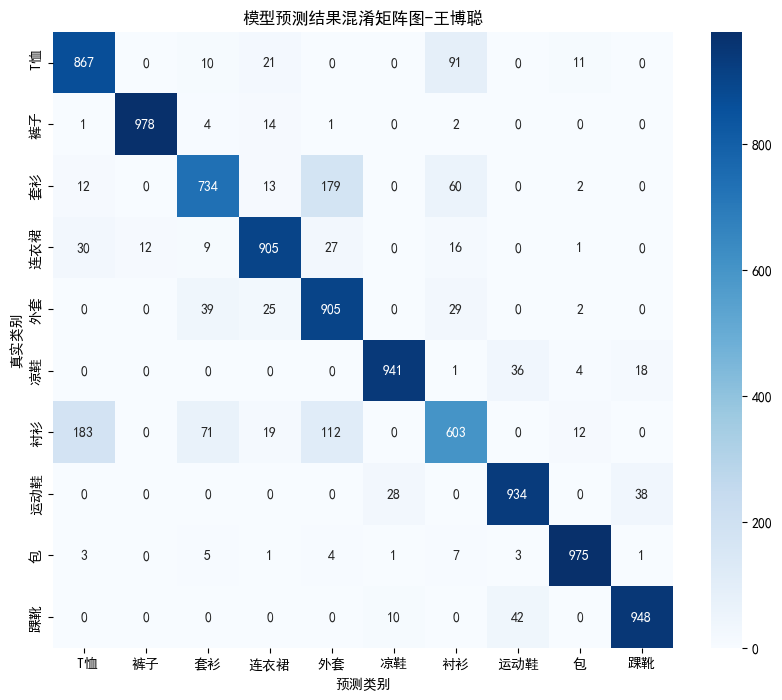

In [35]:
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=Named_labels, yticklabels=Named_labels)
plt.xlabel('预测类别')
plt.ylabel('真实类别')
plt.title('模型预测结果混淆矩阵图-王博聪')
plt.show()

# 各类别预测准确率可视化

将分类模型在各个类别上的预测准确率以柱状图的形式进行可视化展示。它通过计算混淆矩阵中每个类别的准确率，并使用 matplotlib 库绘制柱状图，让模型在不同类别上的性能表现一目了然，便于快速识别模型的优势和劣势类别。

核心步骤总览

1. 计算准确率
2. 初始化图形
3. 绘制柱状图
4. 美化图表
5. 显示结果

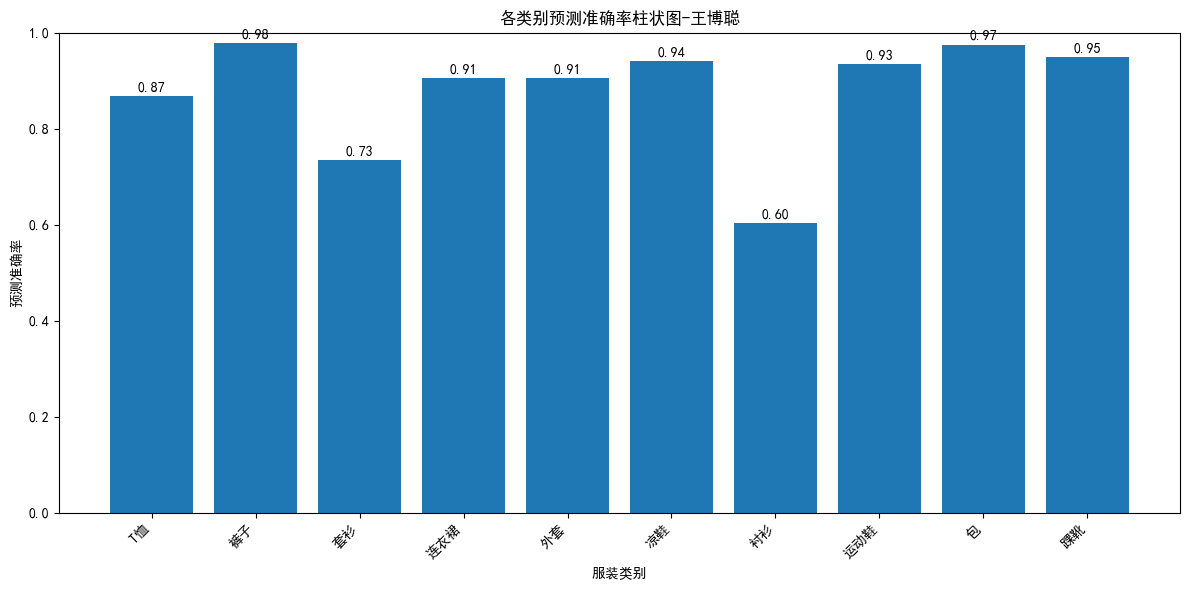

In [36]:
class_accuracy = cm.diagonal() / cm.sum(axis=1)

plt.figure(figsize=(12, 6))
plt.bar(Named_labels, class_accuracy)
plt.xticks(rotation=45, ha='right')
plt.ylim([0, 1])
plt.xlabel('服装类别')
plt.ylabel('预测准确率')
plt.title('各类别预测准确率柱状图-王博聪')

# 在柱状图上方显示准确率数值
for i, v in enumerate(class_accuracy):
    plt.text(i, v + 0.01, f'{v:.2f}', ha='center')

plt.tight_layout()
plt.show()

# 测试集预测结果保存

对测试集进行模型预测，并把预测结果保存到 CSV 文件里。通过遍历测试数据集，逐批次获取图像并进行预测，随后将预测结果和真实标签整合到一个 DataFrame 中，最终以 CSV 格式存储，方便后续的分析与评估。

核心步骤总览
1. 初始化预测结果列表

2. 遍历测试数据集进行预测

3. 创建评估结果字典

4. 转换为 DataFrame 并保存为 CSV

In [37]:
# 对整个测试集进行预测
all_test_preds = []
for X_test, _ in test_dataset:  # 只需要图像数据，忽略标签
    batch_logits = model(X_test, training=False)  # 预测logits
    batch_preds = tf.argmax(batch_logits, axis=1).numpy()  # 转换为类别索引
    all_test_preds.extend(batch_preds)  # 收集所有批次的预测结果

# 创建评估结果DataFrame并保存为CSV
evaluation_results = {
    '真实标签': test_labels,
    '预测标签': all_test_preds,  # 使用正确的预测结果变量
    '是否正确': ['True' if true == pred else 'False' for true, pred in zip(test_labels, all_test_preds)]  # 修正引号
}
test_df = pd.DataFrame(evaluation_results)
test_df.to_csv('./dnn_results.csv', index=False)